<a href="https://colab.research.google.com/github/vishwajitsen/Fuel_Price_Optimisation/blob/main/Fuel_Price_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Cell 1 — Mount Drive and set paths
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

from pathlib import Path
import os

PROJECT_DIR = Path("/content/drive/MyDrive/Fuel_Price_Optimisation/common")
OUTDIR = PROJECT_DIR / "Output_GA_RF"

if not PROJECT_DIR.exists():
    raise FileNotFoundError(f"Project folder not found: {PROJECT_DIR}")

os.makedirs(OUTDIR, exist_ok=True)

print("Project dir:", PROJECT_DIR)
print("Output dir:", OUTDIR)
print("Project contents:")
for p in sorted(PROJECT_DIR.glob("*")):
    print(" -", p.name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project dir: /content/drive/MyDrive/Fuel_Price_Optimisation/common
Output dir: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF
Project contents:
 - Output_GA_RF
 - __pycache__
 - data
 - ml_price_optimizerRF.py
 - ml_price_optimizer_GA.py
 - outputsGA
 - outputsRF


In [19]:
# Cell 2 — Install packages needed for .xlsx and ML
!pip install -q openpyxl scikit-learn matplotlib pandas numpy


In [20]:
# Cell 3 — All helper functions + Random Forest + GA
import json
import os
from typing import Tuple, List, Dict, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- Basics ----------
def ensure_dir(p: str):
    if p:
        Path(p).mkdir(parents=True, exist_ok=True)

def save_json(obj: Dict[str, Any], out_file: str):
    ensure_dir(os.path.dirname(out_file))
    Path(out_file).write_text(json.dumps(obj, indent=2))
    print(f"Saved JSON: {out_file}")

def save_excel(df: pd.DataFrame, path: str):
    ensure_dir(os.path.dirname(path))
    df.to_excel(path, index=False)
    print(f"Saved Excel: {path}")

def save_plot(fig, path: str, show_now: bool = True):
    ensure_dir(os.path.dirname(path))
    fig.savefig(path, bbox_inches="tight")
    if show_now:
        plt.show()
    plt.close(fig)
    print(f"Saved plot: {path}")

# ---------- Data loading ----------
def load_history(path: str) -> pd.DataFrame:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"History file not found: {path}")
    if p.suffix.lower() in (".xlsx", ".xls"):
        df = pd.read_excel(p)
    else:
        df = pd.read_csv(p)
    # standardize columns
    df.columns = [c.strip().lower() for c in df.columns]
    if "date" not in df.columns:
        raise ValueError("History file must contain a 'date' column")
    df["date"] = pd.to_datetime(df["date"])

    expected = {"date","price","cost","comp1_price","comp2_price","comp3_price","volume"}
    missing = expected - set(df.columns)
    if missing:
        raise ValueError(f"History file is missing columns: {missing}")

    df = df.sort_values("date").reset_index(drop=True)
    return df

def load_today(path: str) -> Dict[str, Any]:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Today JSON not found: {path}")
    j = json.loads(p.read_text())
    required = {"date","price","cost","comp1_price","comp2_price","comp3_price"}
    missing = required - set(j.keys())
    if missing:
        raise ValueError(f"today json missing keys: {missing}")
    today = {
        "date": pd.to_datetime(j["date"]),
        "price": float(j["price"]),
        "cost": float(j["cost"]),
        "comp1_price": float(j["comp1_price"]),
        "comp2_price": float(j["comp2_price"]),
        "comp3_price": float(j["comp3_price"]),
    }
    today["comp_mean"] = float(np.mean([today["comp1_price"], today["comp2_price"], today["comp3_price"]]))
    today["comp_min"] = float(min(today["comp1_price"], today["comp2_price"], today["comp3_price"]))
    today["comp_max"] = float(max(today["comp1_price"], today["comp2_price"], today["comp3_price"]))
    return today

# ---------- EDA ----------
def data_summary(df: pd.DataFrame):
    print("\n--- DATA SUMMARY ---")
    print("Shape:", df.shape)
    print("Date range:", df["date"].min().date(), "to", df["date"].max().date())
    print("\nSample:")
    display(df.head(5))
    print("\nMissing values per column:")
    print(df.isna().sum())
    print("\nNumeric summary:")
    display(df.describe().transpose())
    print("--- END ---\n")

# ---------- Feature engineering ----------
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["dow"] = df["date"].dt.dayofweek
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    df["month"] = df["date"].dt.month
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    df["dayofyear"] = df["date"].dt.dayofyear
    df["trend"] = np.arange(len(df))
    return df

def add_competitor_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    comps = df[["comp1_price","comp2_price","comp3_price"]].astype(float)
    df["comp_mean"] = comps.mean(axis=1)
    df["comp_min"] = comps.min(axis=1)
    df["comp_max"] = comps.max(axis=1)
    df["comp_spread"] = df["comp_max"] - df["comp_min"]
    df["price_gap_mean"] = df["price"] - df["comp_mean"]
    df["margin"] = df["price"] - df["cost"]
    return df

def add_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy().sort_values("date")
    df["volume_lag1"] = df["volume"].shift(1)
    df["volume_lag7"] = df["volume"].shift(7)
    df["volume_roll7"] = df["volume"].shift(1).rolling(7).mean()
    df["price_lag1"] = df["price"].shift(1)
    df["price_lag7"] = df["price"].shift(7)
    df["price_roll7"] = df["price"].shift(1).rolling(7).mean()
    df["price_gap_mean_lag1"] = df["price_gap_mean"].shift(1)
    df["price_gap_mean_lag7"] = df["price_gap_mean"].shift(7)
    df["price_gap_mean_roll7"] = df["price_gap_mean"].shift(1).rolling(7).mean()
    df = df.dropna().reset_index(drop=True)
    return df

def build_features(df: pd.DataFrame, with_lags: bool = True) -> pd.DataFrame:
    df2 = add_calendar_features(df)
    df2 = add_competitor_features(df2)
    if with_lags:
        df2 = add_lag_features(df2)
    return df2

# ---------- Split, selection, metrics ----------
def time_train_test_split(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    n = len(df)
    if n < 10:
        raise ValueError("Not enough data for reliable split")
    split_at = int(n * (1.0 - test_size))
    train = df.iloc[:split_at].reset_index(drop=True)
    test = df.iloc[split_at:].reset_index(drop=True)
    return train, test

def select_top_features_by_importance_rf(X_train: pd.DataFrame, y_train: pd.Series, top_k: int = 12, random_state: int = 42) -> List[str]:
    rf = RandomForestRegressor(
        n_estimators=400,
        random_state=random_state,
        n_jobs=-1,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1
    )
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    print("\nFeature importances (top):")
    display(feat_imp.head(top_k).to_frame("importance"))
    return list(feat_imp.head(top_k).index), feat_imp

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = float(r2_score(y_true, y_pred))
    mask = (y_true != 0)
    mape = float(np.nan) if mask.sum() == 0 else (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100.0
    return {"mae": float(mae), "rmse": float(rmse), "r2": float(r2), "mape_pct": float(mape)}

def compute_cv_r2_rf(X: pd.DataFrame, y: pd.Series, n_splits: int = 3, random_state: int = 42) -> float:
    tss = TimeSeriesSplit(n_splits=n_splits)
    r2s = []
    for train_idx, val_idx in tss.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        m = RandomForestRegressor(n_estimators=400, random_state=random_state, n_jobs=-1)
        m.fit(X_tr, y_tr)
        preds = m.predict(X_val)
        r2s.append(r2_score(y_val, preds))
    return float(np.mean(r2s))

# ---------- Plot helpers (save+show) ----------
def plot_feature_importances(series: pd.Series, out_file: str, top_n: int = 25):
    fig, ax = plt.subplots(figsize=(8, max(4, 0.3 * min(len(series), top_n))))
    series.head(top_n).sort_values().plot(kind="barh", ax=ax)
    ax.set_title("Feature Importances (Random Forest)")
    ax.set_xlabel("Importance")
    save_plot(fig, out_file, show_now=True)

def plot_pred_vs_actual(y_true_train, y_pred_train, y_true_test, y_pred_test, out_file):
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].scatter(y_true_train, y_pred_train, alpha=0.4)
    axes[0].set_title("Train: Predicted vs Actual"); axes[0].set_xlabel("Actual"); axes[0].set_ylabel("Predicted")
    axes[1].scatter(y_true_test, y_pred_test, alpha=0.4)
    axes[1].set_title("Test: Predicted vs Actual"); axes[1].set_xlabel("Actual"); axes[1].set_ylabel("Predicted")
    save_plot(fig, out_file, show_now=True)

def plot_candidates_grid(df_candidates: pd.DataFrame, out_file: str, recommended: float = None):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(df_candidates["candidate_price"], df_candidates["expected_profit"], marker='o')
    if recommended is not None:
        ax.axvline(recommended, color='red', linestyle='--', label=f"recommended {recommended:.2f}")
        ax.legend()
    ax.set_xlabel("Candidate price")
    ax.set_ylabel("Expected profit")
    ax.set_title("Profit vs Price Grid (Reference)")
    save_plot(fig, out_file, show_now=True)

def plot_ga_history(history_df: pd.DataFrame, out_file: str):
    fig, ax = plt.subplots(figsize=(8,4))
    if not history_df.empty:
        ax.plot(history_df["gen"] + 1, history_df["best_profit"], marker='o')
    ax.set_xlabel("Generation")
    ax.set_ylabel("Best profit")
    ax.set_title("GA Best Profit per Generation")
    save_plot(fig, out_file, show_now=True)

# ---------- Candidate grid ----------
def candidate_price_grid(today: Dict[str, Any], low: float = None, high: float = None, step: float = 0.05) -> np.ndarray:
    comp_mean = today["comp_mean"]
    base_low = max(today["cost"] + 0.01, comp_mean - 2.0)
    base_high = comp_mean + 2.0
    if low is not None:
        base_low = max(base_low, low)
    if high is not None:
        base_high = min(base_high, high)
    if base_high - base_low < 0.5:
        base_low = min(base_low, comp_mean - 0.5)
        base_high = max(base_high, comp_mean + 0.5)
    grid = np.round(np.arange(base_low, base_high + 1e-9, step), 2)
    return grid

# ---------- Build today's base features ----------
def build_today_base_features(df_history: pd.DataFrame, today: Dict[str, Any]) -> Dict[str, Any]:
    last = df_history.sort_values("date").iloc[-1]
    base = {
        "cost": today["cost"],
        "comp_mean": today["comp_mean"],
        "comp_min": today["comp_min"],
        "comp_max": today["comp_max"],
        "comp_spread": today["comp_max"] - today["comp_min"],
        "dow": int(pd.Timestamp(today["date"]).dayofweek),
        "month": int(pd.Timestamp(today["date"]).month),
        "week": int(pd.Timestamp(today["date"]).isocalendar().week),
        "dayofyear": int(pd.Timestamp(today["date"]).dayofyear),
        "is_weekend": int(pd.Timestamp(today["date"]).dayofweek >= 5),
        "trend": len(df_history) + 1,
        "volume_lag1": float(last["volume"]),
        "volume_lag7": float(df_history.iloc[-7]["volume"]) if len(df_history) >= 7 else float(last["volume"]),
        "volume_roll7": float(df_history["volume"].tail(7).mean()) if len(df_history) >= 7 else float(df_history["volume"].mean()),
        "price_lag1": float(last["price"]),
        "price_lag7": float(df_history.iloc[-7]["price"]) if len(df_history) >= 7 else float(last["price"]),
        "price_roll7": float(df_history["price"].tail(7).mean()) if len(df_history) >= 7 else float(df_history["price"].mean()),
        "price_gap_mean_lag1": float((last["price"] - last[["comp1_price","comp2_price","comp3_price"]].mean())),
        "price_gap_mean_lag7": float((df_history.iloc[-7]["price"] - df_history.iloc[-7][["comp1_price","comp2_price","comp3_price"]].mean())) if len(df_history) >= 7 else 0.0,
        "price_gap_mean_roll7": float(((df_history["price"] - df_history[["comp1_price","comp2_price","comp3_price"]].mean(axis=1))).tail(7).mean()) if len(df_history) >= 7 else 0.0
    }
    return base

# ---------- Genetic Algorithm using Random Forest predictor ----------
class GeneticOptimizer:
    def __init__(
        self,
        predictor: RandomForestRegressor,
        df_history: pd.DataFrame,
        today: Dict[str, Any],
        selected_features: List[str],
        avg_cv_r2: float = 0.0,
        r2_alpha: float = 0.7,
        r2_beta: float = 0.3,
        pop_size: int = 100,
        generations: int = 50,
        crossover_prob: float = 0.6,
        mutation_prob: float = 0.3,
        elite_size: int = 5,
        price_step: float = 0.01,
        seed: int = 42
    ):
        self.predictor = predictor
        self.df_history = df_history
        self.today = today
        self.selected_features = selected_features
        self.avg_cv_r2 = float(max(0.0, avg_cv_r2))
        self.r2_alpha = float(r2_alpha)
        self.r2_beta = float(r2_beta)
        self.pop_size = pop_size
        self.generations = generations
        self.cx_prob = crossover_prob
        self.mut_prob = mutation_prob
        self.elite_size = elite_size
        self.price_step = price_step
        self.rng = np.random.default_rng(seed)

        comp_mean = today["comp_mean"]
        low = max(today["cost"] + 0.01, comp_mean - 2.0)
        high = comp_mean + 2.0
        if high - low < 0.5:
            low = comp_mean - 0.5
            high = comp_mean + 0.5
        self.low = round(low - 0.5, 2)
        self.high = round(high + 0.5, 2)

        # guardrails
        self.max_daily_change = 1.0
        self.min_margin = 0.10
        self.keep_within_competitors = True
        self.comp_band = 0.75

    def apply_guardrails(self, p: float) -> float:
        p = float(p)
        p = max(p, self.today["cost"] + self.min_margin)
        p = min(p, self.today["price"] + self.max_daily_change)
        p = max(p, self.today["price"] - self.max_daily_change)
        if self.keep_within_competitors:
            p = min(p, self.today["comp_mean"] + self.comp_band)
            p = max(p, self.today["comp_mean"] - self.comp_band)
        return round(p, 2)

    def _features_for_prices(self, prices: np.ndarray) -> pd.DataFrame:
        base = build_today_base_features(self.df_history, self.today)
        rows = []
        for p in prices:
            feat = base.copy()
            feat["price"] = float(p)
            feat["margin"] = float(p - base["cost"])
            feat["price_gap_mean"] = float(p - base["comp_mean"])
            rows.append(feat)
        X = pd.DataFrame(rows)
        for c in self.selected_features:
            if c not in X.columns:
                X[c] = 0.0
        X = X[self.selected_features]
        return X

    def evaluate_population(self, pop: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        pop_guarded = np.array([self.apply_guardrails(p) for p in pop])
        X = self._features_for_prices(pop_guarded)
        preds = np.array(self.predictor.predict(X))
        preds = np.maximum(0.0, preds)
        profits = (pop_guarded - self.today["cost"]) * preds
        return profits, pop_guarded, preds

    def initialize_population(self) -> np.ndarray:
        raw = self.rng.uniform(self.low, self.high, size=self.pop_size)
        return np.round(raw / self.price_step) * self.price_step

    def tournament_selection(self, pop: np.ndarray, fitnesses: np.ndarray, k: int = 3) -> np.ndarray:
        idx = []
        for _ in range(len(pop)):
            competitors = self.rng.integers(0, len(pop), size=k)
            winner = competitors[np.argmax(fitnesses[competitors])]
            idx.append(winner)
        return pop[idx]

    def crossover(self, parents: np.ndarray) -> np.ndarray:
        children = parents.copy()
        for i in range(0, len(parents)-1, 2):
            if np.random.random() < self.cx_prob:
                p1 = parents[i]
                p2 = parents[i+1]
                alpha = np.random.random()
                c1 = alpha*p1 + (1-alpha)*p2
                c2 = alpha*p2 + (1-alpha)*p1
                children[i] = np.round(c1 / self.price_step) * self.price_step
                children[i+1] = np.round(c2 / self.price_step) * self.price_step
        return children

    def mutate(self, pop: np.ndarray) -> np.ndarray:
        scale = 0.10 * (self.high - self.low)
        for i in range(len(pop)):
            if np.random.random() < self.mut_prob:
                pop[i] += np.random.normal(0, scale)
                pop[i] = min(max(pop[i], self.low), self.high)
                pop[i] = np.round(pop[i] / self.price_step) * self.price_step
        return pop

    def run(self) -> Dict[str, Any]:
        pop = self.initialize_population()
        best_history, mean_history, all_best = [], [], []

        profits, pop_guarded, preds = self.evaluate_population(pop)
        for gen in range(self.generations):
            # fitness uses generalization multiplier
            gen_weight = (self.r2_alpha + self.r2_beta * max(0.0, self.avg_cv_r2))
            fitnesses = profits * gen_weight

            # elitism
            elite_idx = np.argsort(-fitnesses)[:self.elite_size]
            elites = pop[elite_idx].copy()

            # selection, crossover, mutation
            selected = self.tournament_selection(pop, fitnesses, k=3)
            children = self.crossover(selected)
            children = self.mutate(children)

            # next gen + put back elites
            pop = children
            pop[:self.elite_size] = elites

            # evaluate
            profits, pop_guarded, preds = self.evaluate_population(pop)
            fitnesses = profits * gen_weight
            best_idx = int(np.argmax(fitnesses))
            best_price = float(pop_guarded[best_idx])
            best_profit = float(profits[best_idx])
            mean_profit = float(np.mean(profits))
            best_history.append(best_profit)
            mean_history.append(mean_profit)
            all_best.append({"gen": gen, "best_price": best_price, "best_profit": best_profit})

            if (gen % 5 == 0) or (gen == self.generations-1):
                print(f"GA gen {gen+1}/{self.generations}: best_price={best_price:.2f}, best_profit={best_profit:.2f}, mean_profit={mean_profit:.2f}, gen_weight={gen_weight:.3f}")

        # final best
        gen_weight = (self.r2_alpha + self.r2_beta * max(0.0, self.avg_cv_r2))
        fitnesses = profits * gen_weight
        best_idx = int(np.argmax(fitnesses))
        best_price_raw = float(pop[best_idx])
        best_price_guarded = float(pop_guarded[best_idx])
        best_volume = float(preds[best_idx])
        best_profit = float(profits[best_idx])

        history_df = pd.DataFrame(all_best)
        pop_final_df = pd.DataFrame({
            "price_raw": pop,
            "price_guarded": pop_guarded,
            "pred_volume": preds,
            "profit": profits
        }).sort_values("profit", ascending=False).reset_index(drop=True)

        return {
            "best_price_raw": best_price_raw,
            "best_price_guarded": best_price_guarded,
            "best_volume": best_volume,
            "best_profit": best_profit,
            "history": history_df,
            "pop_final": pop_final_df,
            "best_history": best_history,
            "mean_history": mean_history
        }

# ---------- File auto-discovery ----------
def autodiscover_files(project_dir: Path, data_file: Optional[str], today_file: Optional[str]):
    df_path = None
    today_path = None

    if data_file:
        p = Path(data_file)
        if not p.exists():
            raise FileNotFoundError(f"Provided data path not found: {data_file}")
        df_path = p
    else:
        candidates = list(project_dir.glob("*.xlsx")) + list(project_dir.glob("*.xls")) + list(project_dir.glob("*.csv"))
        candidates += list(project_dir.glob("data/*.xlsx")) + list(project_dir.glob("data/*.csv"))
        if candidates:
            df_path = candidates[0]

    if today_file:
        p = Path(today_file)
        if not p.exists():
            raise FileNotFoundError(f"Provided today path not found: {today_file}")
        today_path = p
    else:
        cand = list(project_dir.glob("*.json")) + list(project_dir.glob("data/*.json"))
        chosen = None
        for c in cand:
            if "today" in c.name.lower():
                chosen = c; break
        today_path = chosen or (cand[0] if cand else None)

    return df_path, today_path

print("Helpers loaded.")


Helpers loaded.


In [22]:
# Cell 4 — Configuration
from pathlib import Path

# Set explicit filenames here (or leave as None to auto-discover)
DATA_FILE = None     # e.g. PROJECT_DIR / "oil_retail_history.xlsx"
TODAY_FILE = None    # e.g. PROJECT_DIR / "today_example.json"

# Model/GA params (Random Forest + GA)
CFG = {
    "test_size": 0.2,   # holdout fraction at the end (time-ordered)
    "top_k": 12,        # number of features to keep after selection
    "cv_splits": 3,     # TimeSeriesSplit folds for CV R^2
    "rf_n_estimators": 600,  # for final RF train
    "rf_random_state": 42,

    # GA params
    "pop": 120,
    "gens": 80,
    "cx": 0.6,
    "mut": 0.25,
    "elite": 6,

    # fitness regularization
    "r2_alpha": 0.7,
    "r2_beta": 0.3,

    # reference sweep step
    "grid_step": 0.05
}

print("Config ready.")


Config ready.


In [23]:
# Cell 5 — Load data & today JSON, run EDA
data_path, today_path = autodiscover_files(PROJECT_DIR, DATA_FILE, TODAY_FILE)
if data_path is None or today_path is None:
    raise FileNotFoundError("Could not auto-discover data and/or today JSON. Set DATA_FILE/TODAY_FILE explicitly.")

print("Using history file:", data_path)
print("Using today file:", today_path)

df = load_history(str(data_path))
today = load_today(str(today_path))

data_summary(df)


Using history file: /content/drive/MyDrive/Fuel_Price_Optimisation/common/data/oil_retail_history.xlsx
Using today file: /content/drive/MyDrive/Fuel_Price_Optimisation/common/data/today_example.json

--- DATA SUMMARY ---
Shape: (730, 7)
Date range: 2023-01-01 to 2024-12-30

Sample:


,date,price,cost,comp1_price,comp2_price,comp3_price,volume
0,2023-01-01,97.66,86.46,98.39,99.10,97.37,13513
1,2023-01-02,96.46,87.25,95.37,96.25,97.38,13605
2,2023-01-03,94.67,86.40,94.41,94.69,94.50,16540
3,2023-01-04,97.32,87.51,99.12,96.90,97.54,14927
4,2023-01-05,94.08,86.38,93.31,94.61,93.85,13332



Missing values per column:
date           0
price          0
cost           0
comp1_price    0
comp2_price    0
comp3_price    0
volume         0
dtype: int64

Numeric summary:


,count,mean,min,25%,50%,75%,max,std
date,730,2023-12-31 12:00:00,2023-01-01 00:00:00,2023-07-02 06:00:00,2023-12-31 12:00:00,2024-06-30 18:00:00,2024-12-30 00:00:00,NaN
price,730.0,96.505301,88.08,94.67,96.525,98.42,104.89,2.747598
cost,730.0,86.498178,83.34,85.3025,86.255,87.61,91.86,1.575689
comp1_price,730.0,96.551658,88.32,94.555,96.59,98.4675,104.2,2.779654
comp2_price,730.0,96.530068,87.07,94.8275,96.43,98.4475,105.0,2.796763
comp3_price,730.0,96.45726,86.08,94.7125,96.515,98.0975,104.36,2.782295
volume,730.0,13960.983562,11397.0,13326.25,13882.0,14538.75,16890.0,905.91236


--- END ---



In [24]:
# Cell 6 — Build features (incl. lags)
df_feat = build_features(df, with_lags=True)
print("Rows after features:", len(df_feat))
display(df_feat.head(3))


Rows after features: 723


,date,price,cost,comp1_price,comp2_price,comp3_price,volume,dow,is_weekend,month,...,margin,volume_lag1,volume_lag7,volume_roll7,price_lag1,price_lag7,price_roll7,price_gap_mean_lag1,price_gap_mean_lag7,price_gap_mean_roll7
0,2023-01-08,100.89,88.00,101.76,101.22,101.35,14638,6,1,1,...,12.89,13603.0,13513.0,14166.142857,98.63,97.66,96.507143,-0.326667,-0.626667,-0.222857
1,2023-01-09,97.71,88.68,99.49,99.68,97.38,13867,0,0,1,...,9.03,14638.0,13605.0,14326.857143,100.89,96.46,96.968571,-0.553333,0.126667,-0.212381
2,2023-01-10,97.14,89.05,96.02,98.24,96.82,13471,1,0,1,...,8.09,13867.0,16540.0,14364.285714,97.71,94.67,97.147143,-1.140000,0.136667,-0.393333


Train rows: 578, Test rows: 145

Feature importances (top):


,importance
dow,0.350460
price_gap_mean,0.084820
margin,0.049698
comp_spread,0.041286
volume_lag7,0.040469
volume_roll7,0.040164
price_lag1,0.036380
price_gap_mean_lag1,0.036297
volume_lag1,0.035213
price_gap_mean_lag7,0.033951


Selected features: ['dow', 'price_gap_mean', 'margin', 'comp_spread', 'volume_lag7', 'volume_roll7', 'price_lag1', 'price_gap_mean_lag1', 'volume_lag1', 'price_gap_mean_lag7', 'cost', 'price_roll7']


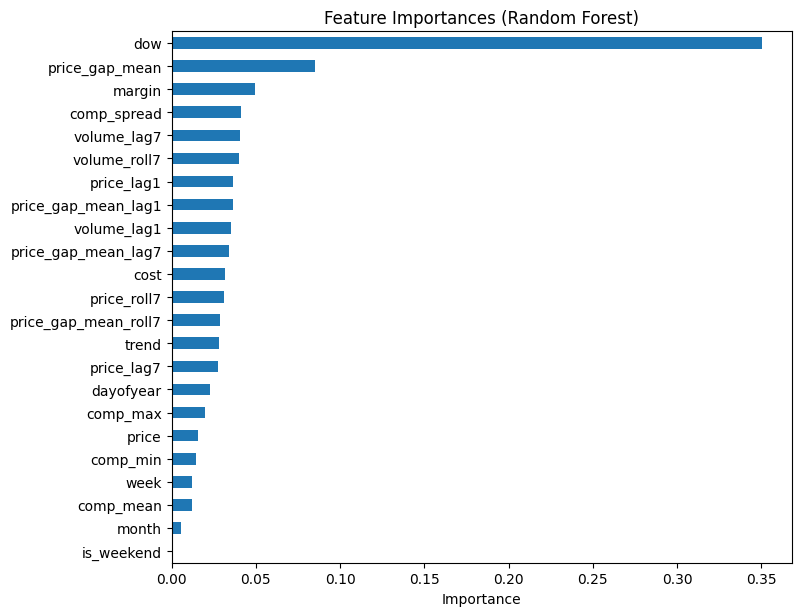

Saved plot: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF/feature_importances_rf.png


In [25]:
# Cell 7 — Split and feature selection
train_df, test_df = time_train_test_split(df_feat, test_size=CFG["test_size"])
print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

candidate_features = [
    "price","cost","comp_mean","comp_min","comp_max","price_gap_mean",
    "comp_spread","margin",
    "dow","month","week","dayofyear","is_weekend","trend",
    "volume_lag1","volume_lag7","volume_roll7",
    "price_lag1","price_lag7","price_roll7",
    "price_gap_mean_lag1","price_gap_mean_lag7","price_gap_mean_roll7"
]
candidate_features = [f for f in candidate_features if f in train_df.columns]

X_train = train_df[candidate_features].copy()
y_train = train_df["volume"].astype(float).copy()
X_test = test_df[candidate_features].copy()
y_test = test_df["volume"].astype(float).copy()

top_k = min(CFG["top_k"], len(candidate_features))
selected, rf_importances_full = select_top_features_by_importance_rf(X_train, y_train, top_k=top_k, random_state=CFG["rf_random_state"])
print("Selected features:", selected)

# Save + plot importances
importances_path_csv = OUTDIR / "feature_importances_rf.csv"
importances_path_png = OUTDIR / "feature_importances_rf.png"
rf_importances_full.sort_values(ascending=False).to_csv(importances_path_csv, header=["importance"])
plot_feature_importances(rf_importances_full.sort_values(ascending=False), str(importances_path_png))

X_train_sel = X_train[selected].copy()
X_test_sel  = X_test[selected].copy()


TRAIN metrics: {'mae': 211.5717243367935, 'rmse': 273.12323369968453, 'r2': 0.9079339235908083, 'mape_pct': 1.5100780545964556}
TEST  metrics: {'mae': 573.4478390804597, 'rmse': 739.5580944035798, 'r2': 0.3444156619938883, 'mape_pct': 4.13852950795477}
Saved JSON: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF/rf_metrics.json


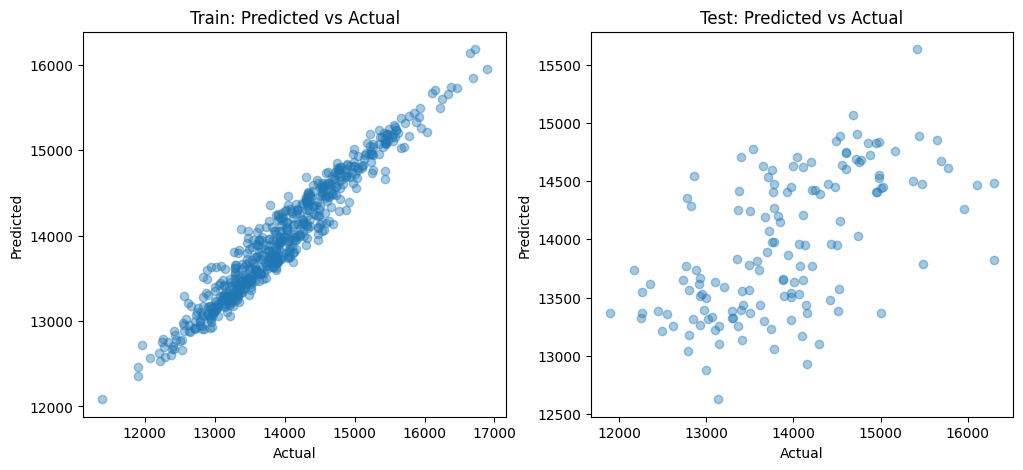

Saved plot: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF/pred_vs_actual_rf.png
Average CV R² (train folds): 0.3096


In [26]:
# Cell 8 — Train RF & evaluate
rf = RandomForestRegressor(
    n_estimators=CFG["rf_n_estimators"],
    random_state=CFG["rf_random_state"],
    n_jobs=-1
)
rf.fit(X_train_sel, y_train)

y_pred_train = rf.predict(X_train_sel)
y_pred_test  = rf.predict(X_test_sel)

metrics_train = compute_metrics(y_train.values, y_pred_train)
metrics_test  = compute_metrics(y_test.values, y_pred_test)

print("TRAIN metrics:", metrics_train)
print("TEST  metrics:", metrics_test)

# Save metrics JSON
save_json(
    {"train": metrics_train, "test": metrics_test},
    str(OUTDIR / "rf_metrics.json")
)

# Pred vs actual plot (save + show)
plot_pred_vs_actual(
    y_train.values, y_pred_train,
    y_test.values,  y_pred_test,
    str(OUTDIR / "pred_vs_actual_rf.png")
)

# Cross-validated R^2 with TimeSeriesSplit
avg_cv_r2 = compute_cv_r2_rf(X_train_sel, y_train, n_splits=CFG["cv_splits"], random_state=CFG["rf_random_state"])
print(f"Average CV R² (train folds): {avg_cv_r2:.4f}")


,candidate_price,pred_volume,expected_profit
0,97.31,13990.448333,161449.773767
1,97.26,13990.385000,160749.523650
2,97.21,13991.511667,160062.893467
3,97.16,13984.701667,159285.751983
4,97.11,13972.748333,158450.966100
5,97.06,13976.441667,157794.026417
6,97.01,13962.888333,156942.864867
7,96.96,13962.040000,156235.227600
8,96.91,13967.231667,155594.960767
9,96.86,13961.355000,154831.426950


Saved Excel: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF/candidate_grid_reference_rf.xlsx


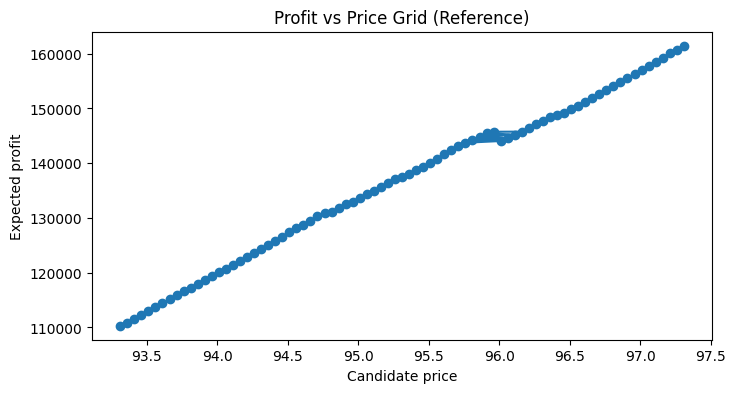

Saved plot: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF/profit_grid_reference_rf.png


In [27]:
# Cell 9 — Reference grid (profit vs price)
grid = candidate_price_grid(today, step=CFG["grid_step"])
base = build_today_base_features(df, today)

rows = []
for p_val in grid:
    feat = base.copy()
    feat["price"] = float(p_val)
    feat["margin"] = float(p_val - today["cost"])
    feat["price_gap_mean"] = float(p_val - base["comp_mean"])

    X_row = pd.DataFrame([feat])
    for col in selected:
        if col not in X_row.columns:
            X_row[col] = 0.0
    X_row = X_row[selected]

    v = float(max(0.0, rf.predict(X_row)[0]))
    profit = (p_val - today["cost"]) * v
    rows.append({"candidate_price": p_val, "pred_volume": v, "expected_profit": profit})

df_grid = pd.DataFrame(rows).sort_values("expected_profit", ascending=False).reset_index(drop=True)
display(df_grid.head(10))

save_excel(df_grid, str(OUTDIR / "candidate_grid_reference_rf.xlsx"))
plot_candidates_grid(df_grid, str(OUTDIR / "profit_grid_reference_rf.png"))


GA gen 1/80: best_price=95.45, best_profit=139212.34, mean_profit=138695.77, gen_weight=0.793
GA gen 6/80: best_price=95.45, best_profit=139212.34, mean_profit=139202.03, gen_weight=0.793
GA gen 11/80: best_price=95.45, best_profit=139212.34, mean_profit=139205.12, gen_weight=0.793
GA gen 16/80: best_price=95.45, best_profit=139212.34, mean_profit=139212.34, gen_weight=0.793
GA gen 21/80: best_price=95.45, best_profit=139212.34, mean_profit=139186.15, gen_weight=0.793
GA gen 26/80: best_price=95.45, best_profit=139212.34, mean_profit=139162.99, gen_weight=0.793
GA gen 31/80: best_price=95.45, best_profit=139212.34, mean_profit=139183.34, gen_weight=0.793
GA gen 36/80: best_price=95.45, best_profit=139212.34, mean_profit=139212.34, gen_weight=0.793
GA gen 41/80: best_price=95.45, best_profit=139212.34, mean_profit=139209.01, gen_weight=0.793
GA gen 46/80: best_price=95.45, best_profit=139212.34, mean_profit=139212.34, gen_weight=0.793
GA gen 51/80: best_price=95.45, best_profit=139212.3

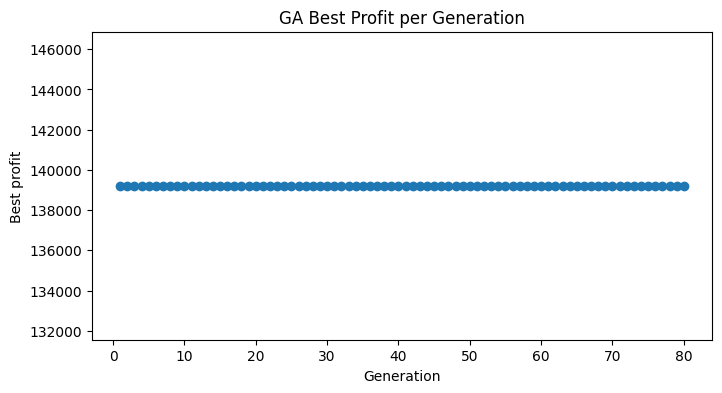

Saved plot: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF/ga_history_rf.png
Saved JSON: /content/drive/MyDrive/Fuel_Price_Optimisation/common/Output_GA_RF/recommendation_ga_rf.json


In [28]:
# Cell 10 — GA run
ga = GeneticOptimizer(
    predictor=rf,
    df_history=df,
    today=today,
    selected_features=selected,
    avg_cv_r2=avg_cv_r2,
    r2_alpha=CFG["r2_alpha"],
    r2_beta=CFG["r2_beta"],
    pop_size=CFG["pop"],
    generations=CFG["gens"],
    crossover_prob=CFG["cx"],
    mutation_prob=CFG["mut"],
    elite_size=CFG["elite"],
    price_step=0.01,
    seed=42
)

ga_res = ga.run()
print("\nGA result:")
print(f"Best raw price:      {ga_res['best_price_raw']:.2f}")
print(f"Best guarded price:  {ga_res['best_price_guarded']:.2f}")
print(f"Predicted volume:    {ga_res['best_volume']:.1f}")
print(f"Predicted profit:    {ga_res['best_profit']:.2f}")

# Save GA outputs
save_excel(ga_res["pop_final"], str(OUTDIR / "ga_population_final_rf.xlsx"))
ga_res["history"].to_csv(OUTDIR / "ga_history_rf.csv", index=False)
plot_ga_history(ga_res["history"], str(OUTDIR / "ga_history_rf.png"))

# Final recommendation JSON
recommendation = {
    "recommended_price": ga_res["best_price_guarded"],
    "best_price_raw": ga_res["best_price_raw"],
    "pred_volume": ga_res["best_volume"],
    "expected_profit": ga_res["best_profit"],
    "today": {
        "date": str(today["date"].date()),
        "yesterday_price": today["price"],
        "cost": today["cost"],
        "comp_mean": today["comp_mean"]
    },
    "model": "RandomForestRegressor",
    "model_metrics": {"train": metrics_train, "test": metrics_test, "avg_cv_r2": avg_cv_r2},
    "selected_features": selected
}
save_json(recommendation, str(OUTDIR / "recommendation_ga_rf.json"))
